# Training Random Forest

Here we train the Random Forest model. First let's load the libraries

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from scifAI.ml.auto_feature_selection import AutoFeatureSelection
from scifAI.utils import list_of_dict_to_dict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import shuffle
import skimage
plt.ion()   # interactive mode
from skimage.transform import   rescale, resize 
import random
#import umap
from tqdm import tqdm
from random import sample
from skimage.transform import resize
import h5py
from skimage.exposure import rescale_intensity
import seaborn as sns
from umap import UMAP

# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.ensemble import RandomForestClassifier

from sklearn import manifold, datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score

In [2]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.dummy import DummyClassifier

def classification_complete_report(estimator, X, y_true, labels = None ,plot = True ): 
    y_pred = estimator.predict(X)
    y_pred_dummy = DummyClassifier().fit(X,y_true).predict(X)
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("No information rate: %.2f" % accuracy_score(y_true, y_pred_dummy) )
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true, labels = labels ,cmap = "Greys", xticks_rotation='vertical')
    

now lets load the data

In [3]:
metadata = pd.read_csv("/pstore/data/DS4/synapse_data_features/metadata_subset.csv.gz")
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1
...,...,...,...,...,...,...,...
1065962,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1
1065963,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1
1065964,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1
1065965,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1


In [4]:

df_features = pd.read_csv("/pstore/data/DS4/synapse_data_features/df_features_subset.csv.gz")
df_features

,mask_based_area_BF,mask_based_bbox_area_BF,mask_based_convex_area_BF,mask_based_eccentricity_BF,mask_based_equivalent_diameter_BF,mask_based_euler_number_BF,mask_based_extent_BF,mask_based_feret_diameter_max_BF,mask_based_filled_area_BF,mask_based_major_axis_length_BF,...,max_intensity_ratio_MHCII_R7_R8,sum_intensity_ratio_CD3_R7_R8,mean_intensity_ratio_CD3_R7_R8,max_intensity_ratio_CD3_R7_R8,sum_intensity_ratio_P-CD3zeta_R7_R8,mean_intensity_ratio_P-CD3zeta_R7_R8,max_intensity_ratio_P-CD3zeta_R7_R8,sum_intensity_ratio_Live-Dead_R7_R8,mean_intensity_ratio_Live-Dead_R7_R8,max_intensity_ratio_Live-Dead_R7_R8
0,2228,3021,2392,0.484394,53.261409,1,0.737504,61.717096,2228,57.336477,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,885,1155,925,0.238094,33.568095,1,0.766234,36.138622,885,34.216438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,656,812,689,0.369856,28.900608,1,0.807882,32.756679,656,30.262314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,753,899,780,0.386491,30.963678,1,0.837597,34.132096,753,32.348559,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1208,1512,1247,0.661747,39.218279,1,0.798942,51.224994,1208,45.782110,...,19.735296,0.465222,0.465222,25.504583,0.481531,0.481531,26.397369,0.754085,0.754085,45.835530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065962,973,1190,997,0.100885,35.197473,1,0.817647,37.215588,973,35.332773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065963,3956,5046,4180,0.787555,70.971372,1,0.783987,91.760558,3956,91.437834,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065964,909,1073,928,0.622298,34.020211,1,0.847158,40.804412,909,38.830446,...,5.716450,0.190820,0.190820,7.474995,0.115499,0.115499,4.191402,1.000000,1.000000,32.928658
1065965,3388,4272,3670,0.875994,65.679035,1,0.793071,90.426766,3388,96.830707,...,6.247939,0.039196,0.039196,124.378412,0.045108,0.045108,140.202637,0.005466,0.005466,16.385927


to avoid using irrelevant or meaningless features in our analysis, we exclude features which include these strings

In [5]:
list_of_features_to_exclude = ["Antibody","Live-Dead","CD18",  "_R2",  "_R3",  "_R8", "background",
                               "moment","percent","mask_based_mean","mask_based_min","mask_based_max",  
                               "RMS","intensity_BF","_R1_R2","_R1_R3","_R1_R4","_R1_R5","_R1_R6","_R1_R7",
                               "_R1_R8","_R2_R1","_R2_R3","_R2_R4","_R2_R5","_R2_R6","_R2_R7","_R2_R8",
                               "_R3_R1","_R3_R2","_R3_R4","_R3_R5","_R3_R6","_R3_R7","_R3_R8",
                               "_R4_R1","_R4_R2","_R4_R3","_R4_R5","_R4_R6","_R4_R7","_R4_R8",
                               "_R5_R1","_R5_R2","_R5_R3","_R5_R4","_R5_R8","_R6_R1","_R6_R2",
                               "_R6_R3","_R6_R4","_R6_R5","_R6_R7","_R6_R8","_R7_R1","_R7_R2",
                               "_R7_R3","_R7_R4","_R7_R5","_R7_R6","_R7_R8","_R8_R1","_R8_R2",
                               "_R8_R3","_R8_R4","_R8_R5","_R8_R6","_R8_R7","cell_distance"]
classification_indx = ~df_features.columns.str.contains( list_of_features_to_exclude[0]) 

for f_to_exclude in list_of_features_to_exclude:
    classification_indx = classification_indx & ~df_features.columns.str.contains( f_to_exclude) 
    

print("list of remained columns:\n", 
      df_features.columns[classification_indx],
     "\n",
     "so we have these many columns:",
     classification_indx.sum())

list of remained columns:
 Index(['mask_based_area_BF', 'mask_based_bbox_area_BF',
       'mask_based_convex_area_BF', 'mask_based_eccentricity_BF',
       'mask_based_equivalent_diameter_BF', 'mask_based_euler_number_BF',
       'mask_based_extent_BF', 'mask_based_feret_diameter_max_BF',
       'mask_based_filled_area_BF', 'mask_based_major_axis_length_BF',
       ...
       'max_intensity_ratio_F-Actin_R5_R7', 'sum_intensity_ratio_MHCII_R5_R7',
       'mean_intensity_ratio_MHCII_R5_R7', 'max_intensity_ratio_MHCII_R5_R7',
       'sum_intensity_ratio_CD3_R5_R7', 'mean_intensity_ratio_CD3_R5_R7',
       'max_intensity_ratio_CD3_R5_R7', 'sum_intensity_ratio_P-CD3zeta_R5_R7',
       'mean_intensity_ratio_P-CD3zeta_R5_R7',
       'max_intensity_ratio_P-CD3zeta_R5_R7'],
      dtype='object', length=247) 
 so we have these many columns: 247


now we use the pre-assigned set of train, validation and test

In [6]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 

indx = metadata.set.isin([ "train", "validation","test" ])
indx = indx & metadata.label.isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & metadata.label.isin(set_of_interesting_classes)
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & metadata.label.isin(set_of_interesting_classes)
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & metadata.label.isin(set_of_interesting_classes)
test_index = test_index[test_index].index

# training the model

Now we can train the model with the optimal top-k and all the available data

In [7]:
top_k = 196

In [8]:
rf = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection( top_k = top_k )),
                 ('RandomForestClassifier', RandomForestClassifier( ) )
        ], verbose=True)

rf.fit(df_features.loc[train_index.tolist() + validation_index.tolist() , classification_indx],  
               metadata.loc[train_index.tolist() + validation_index.tolist() , "label"] )

[Pipeline] .... (step 1 of 3) Processing StandardScaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing AutoFeatureSelection, total=  22.6s
[Pipeline]  (step 3 of 3) Processing RandomForestClassifier, total=   2.4s


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('AutoFeatureSelection', AutoFeatureSelection(top_k=196)),
                ('RandomForestClassifier', RandomForestClassifier())],
         verbose=True)

# Model evaluation

                              precision    recall  f1-score   support

                      B_cell       1.00      0.98      0.99       190
                      T_cell       0.87      0.94      0.90       200
       T_cell_with_signaling       0.91      0.78      0.84       148
T_cell_with_B_cell_fragments       0.96      0.91      0.93       189
       B_T_cell_in_one_layer       0.86      0.92      0.89       161
  Synapses_without_signaling       0.78      0.86      0.82       147
     Synapses_with_signaling       0.85      0.85      0.85       196
    No_cell_cell_interaction       0.95      0.95      0.95       182
                  Multiplets       0.94      0.91      0.92       154

                    accuracy                           0.90      1567
                   macro avg       0.90      0.90      0.90      1567
                weighted avg       0.90      0.90      0.90      1567

------------------------------------------------------------
No information rate: 0.13


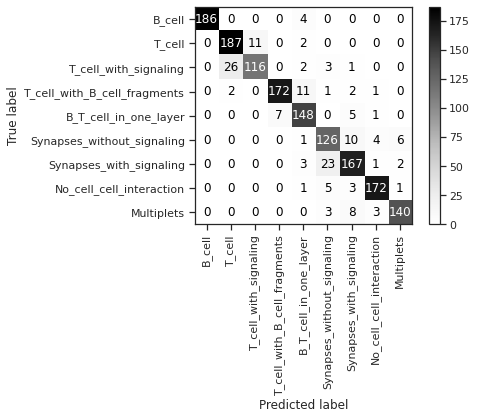

In [9]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")
classification_complete_report(rf, 
                               df_features.loc[test_index, classification_indx],
                               metadata.loc[test_index, "label"], labels = set_of_interesting_classes)

# saving the test set predictions


In [10]:
preds = rf.predict(df_features.loc[test_index, classification_indx])
preds = pd.Series(preds).to_csv("RF_preds.csv")